# Ferret data
First, we load the imaging data used in Macke et al. (2011). Its size is (npixels_x, npixels_y, conditions, trials).

In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(9876)

data = scipy.io.loadmat('data/ferretdata.mat')
data = data['dat'] # data is stored in a dict
data.shape

(126, 252, 8, 100)

Reshape the data to (conditions, trials, npixels_x, npixels_y) and split the data into one part used as "ground truth" (95%) and one part used for inference (5%).

In [31]:
R = np.transpose(data[26:,:200,:,:], (2,3,0,1))
print(R.shape)

# take only a small part of the image (for performance reasons)
#R = R[:,:,38:58,106:136]

# downsample image
#R = R[:,:,::2,::2]

# use 95% of the data as the "ground truth"
# and 5% of the data as real data
idx = np.array([False for i in range(100)])
idx[np.arange(100)[np.random.choice(100, size=5, replace=False)]] = True
R_gt = R[:,~idx,:,:]
R = R[:,idx,:,:]

size = R.shape[2:]
n = size[0] * size[1]
R.shape

(8, 100, 100, 200)


(8, 5, 100, 200)

## Plot responses
Visualize the responses for the small patch

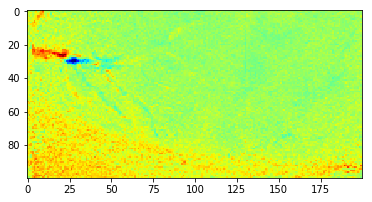

In [33]:
plt.imshow(R[0,np.random.randint(5),:,:], cmap='jet')
plt.show()

## Maximum likelihood solution
Compute the solution using vector averaging (for details see OPM.ipynb)

In [34]:
from opm import calculate_map, plot_opm, plot_amplitude_map
from opm.response import create_stimuli

In [35]:
angles = [i * np.pi / 4 for i in range(4)]*2

V = create_stimuli([1.], angles, 5)
V.shape

(8, 5, 3)

In [40]:
m_gt = calculate_map(R_gt, create_stimuli([1.], angles, 95))
m_gt = m_gt[0] + 1j * m_gt[1]

m_hat = calculate_map(R, V)
m_hat = m_hat[0] + 1j * m_hat[1]

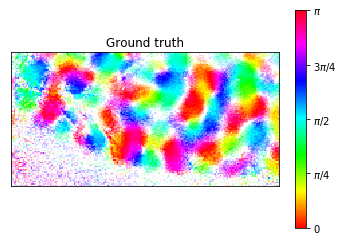

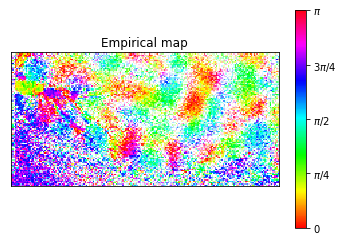

In [41]:
plot_opm(m_gt, pinwheels=False, shade=True, rmax=80, title='Ground truth')
plt.show()

plot_opm(m_hat, pinwheels=False, shade=True, rmax=80, title='Empirical map')
plt.show()

## Gaussian Process method
Compute a smooth OPM using the GP method (see BayesianOPM.ipynb)

In [43]:
from opm.gp import GaussianProcessOPM

In [44]:
gp = GaussianProcessOPM(size=size, prior_method='icd', prior_rank=1600)

In [45]:
mu_post = gp.fit(stimuli=V, responses=R, noise='factoran', verbose=True, noise_kwargs={'iterations':3, 'q':1})

*** Estimating prior hyperparameters ***
{'sigma': 5.970650738019011, 'alpha': 5.881244153874055}
*** Fitting prior ***
*** Fitting posterior ***
Fitting noise model: iteration 1


KeyboardInterrupt: 

In [13]:
gp.save(fname='pkl/ferret_full.pkl')

In [9]:
gp = GaussianProcessOPM.load(fname='pkl/ferret_full.pkl')

In [10]:
#mu = m.reshape(3, size)
result = gp.mu_post[0] + 1j * gp.mu_post[1]

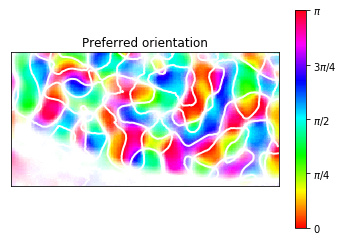

In [11]:
f, ax = plot_opm(result, shade=True, rmax=80)
plt.show()

### Noise covariance
We examine the noise variances (i.e. the diagonal of the noise covariance matrix).

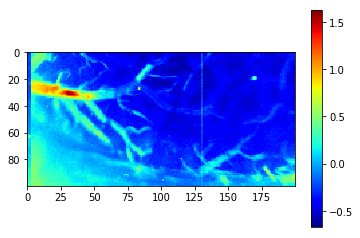

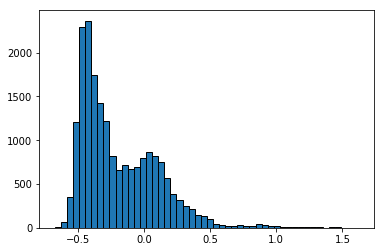

In [12]:
plt.imshow(np.log10(gp.noise.variance).reshape(*R.shape[2:]), cmap='jet')
plt.colorbar()
plt.show()

plt.hist(np.log10(gp.noise.variance), bins=50, edgecolor='black')
plt.show()

In [22]:
def cov2corr(cov):
    std = np.sqrt(np.diag(cov))[:,np.newaxis]
    return cov / std / std.T

In [27]:
def avg_neighbor_corr(gp, radius=2):
    
    # size of the map (x, y)
    size = gp.size
    
    # convert noise covariance to correlation matrix
    #noise_corr = cov2corr(gp.noise.covariance)
    
    # initialize empty image
    neighbor_corr = np.zeros(size)
    
    # for each index
    # i is the 1d index
    # ix is the 2d (x, y) index
    for i, ix in enumerate(gp.idx):
        # compute euclidean distance from this index to all others
        dist = np.sqrt(np.sum(np.square(ix - gp.idx), axis=1))
        
        # keep all indices smaller than some distance
        neighbors = np.where(dist <= radius)[0]
        # remove the index itself
        neighbors = neighbors[neighbors != i]
    
        # compute average correlation between i and the neighbors
        neighbor_corr[ix[0], ix[1]] = np.mean(gp.noise.covariance[i, neighbors] / np.sqrt(gp.noise.covariance[i, i]) / np.sqrt(gp.noise.covariance[neighbors, neighbors]))
            
    return neighbor_corr

In [ ]:
nbcorr = avg_neighbor_corr(gp, radius=2)

plt.imshow(nbcorr, cmap='jet')
plt.colorbar()
plt.show()

plt.hist(nbcorr, bins=50, edgecolor='black')
plt.show()